<a href="https://www.kaggle.com/code/subhadipde2000/text-summarization-gemma-3-fine-tuning-with-lora?scriptVersionId=240309584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing/Updating Necessary Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 17.3 MB/s eta 0:00:00


# Importing Necessary Libraries:

In [2]:
import os
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-17 19:14:48.681984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747509288.866502      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747509288.923171      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Reading the Datasets:

In [5]:
train_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'
valid_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv'
test_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv'

In [6]:
def read_dataset():
    """
    Read all three datasets as a single dataset and shuffle it.
    """
    
    df1 = pd.read_csv(train_dir)
    df2 = pd.read_csv(valid_dir)
    df3 = pd.read_csv(test_dir)
    df = pd.concat([df1, df2, df3])

    df.drop(['id'], axis=1, inplace=True)
    df.rename(columns = {"article":"news", "highlights":"summary"}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [7]:
df = read_dataset()
df.head()

,news,summary
0,Salford maintained their slim hopes of qualify...,Kevin Locke bagged 14 points for the Salford R...
1,"Jennifer K. 'Kaya' Thompson, 44, has now joine...",Jennifer K. 'Kaya' Thompson has now joined 35 ...
2,Occupy Oakland . protesters claimed victory af...,California demonstrators shut down city's port...
3,"Atlanta, Georgia (CNN) -- A federal lawsuit wa...",Gay bar patrons allege police used anti-gay sl...
4,By . Associated Press . Texas pastor Joel Oste...,"Osten already preaches to 40,000 people each w..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311971 entries, 0 to 311970
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   news     311971 non-null  object
 1   summary  311971 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


# Exploratory Data Analysis:

In [9]:
def plot():
    
    df["news length"] = df["news"].apply(lambda x: len(x.split()))
    df["summary length"] = df["summary"].apply(lambda x: len(x.split()))
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250)
    sns.histplot(data=df, x="news length", bins=100, ax=axes[0], kde=True).set_title("Distribution of news lengths (number of words)")
    sns.histplot(data=df, x="summary length", bins=500, ax=axes[1], kde=True).set_title("Distribution of summary lengths (number of words)")
    axes[1].set_xlim(0, 175)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    return

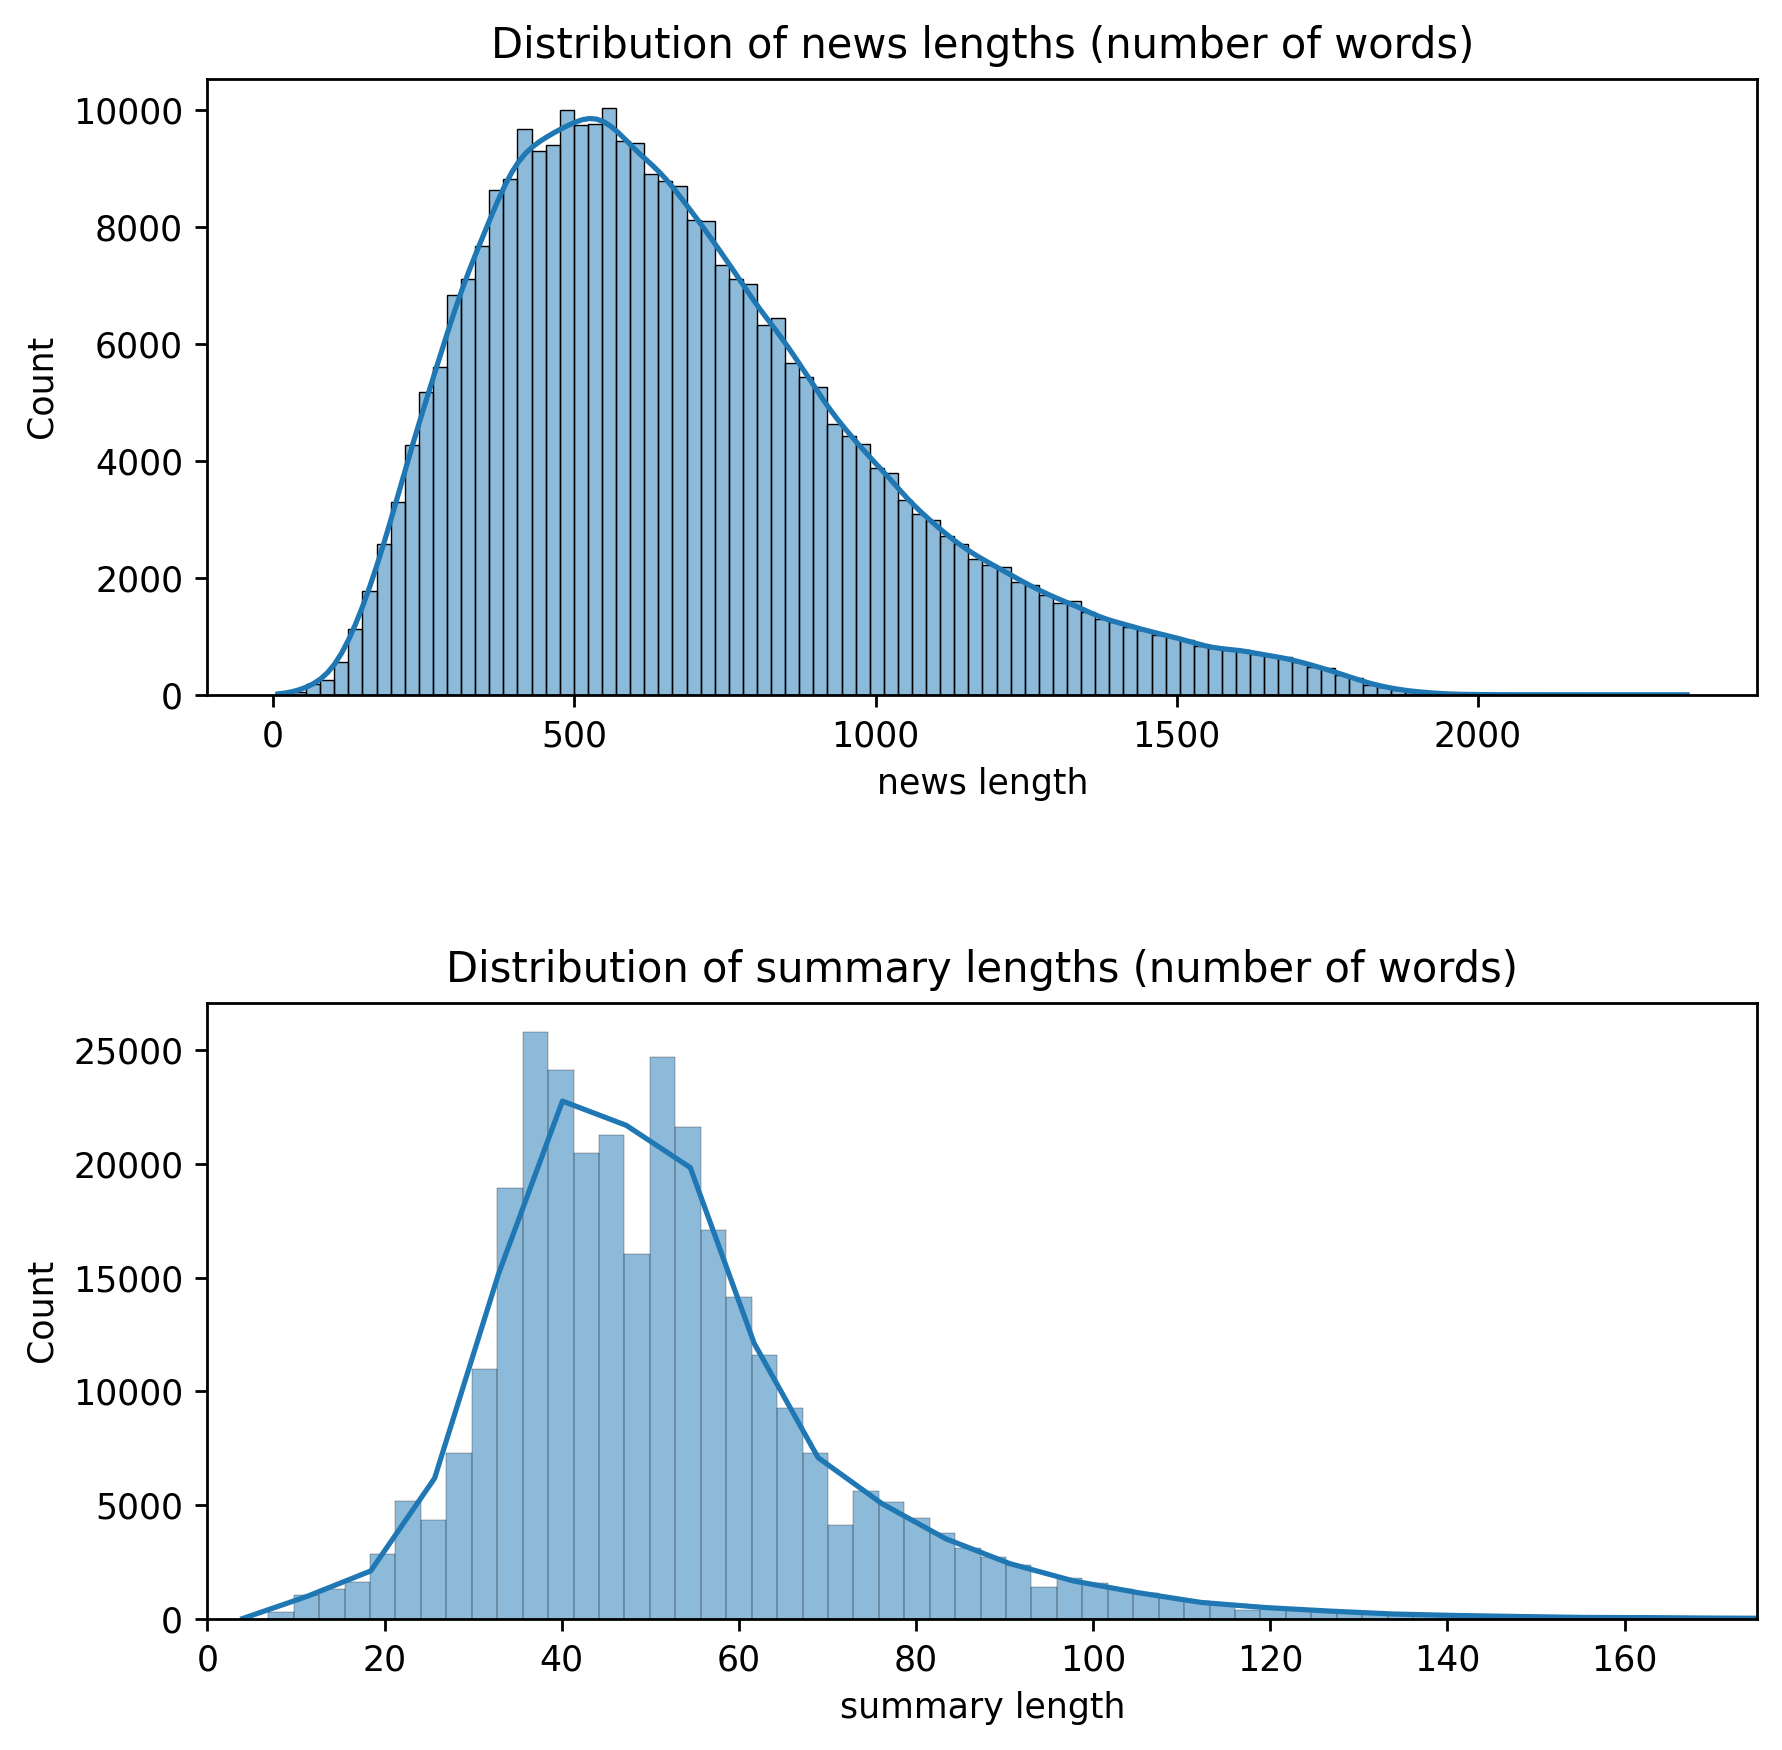

In [10]:
plot()

# Function for Coloring and Formatting Text:

In [11]:
def colorize_text(text):
    for word, color in zip(["System: ", "Instructions: ", "News: ", "Summary: "], ["aquamarine", "yellow", "crimson", "cyan"]):
        text = text.replace(f"{word}", f"<font color='{color}' size='4'><strong>{word}</strong></font>")
    return text

In [12]:
# Visualizing a random example:

row = df.loc[random.randint(0, len(df))]
text = f"News: \n\n{row.news} \n\nSummary: \n\n{row.summary}"
display(Markdown(colorize_text(text)))

<font color='crimson' size='4'><strong>News: </strong></font>

By . Daily Mail Reporter . PUBLISHED: . 17:31 EST, 8 August 2012 . | . UPDATED: . 19:05 EST, 8 August 2012 . Newly released documents show that Robert F. Kennedy Jr. told police that on the day before his wife hanged herself, she told him 'everything was her fault.' Papers released Wednesday by the Bedford Police Department in New York include a statement Mr Kennedy gave a detective after Mary Kennedy's body was discovered after she killed herself on May 16. Kennedy said that his wife called him on May 15. ‘She told me she was sorry for everything. She said I was right about everything, and everything was her fault. She then told me she needed me to take care of her,’ he reportedly told Bedford police. How they used to be: Robert Kennedy Jr. and his estranged wife Mary were in the midst of an ongoing divorce battle at the time of her suicide in May . Much of the statement was blacked out so that it could not be read publicly before it was released. The visible portion does not make clear what Mary Kennedy meant by 'everything.' A day after RFK Jr. rebuffed Mary’s desperate plea for his help, she was found hanged in their barn. Depression: The day before her death, Mary called Bobby asking for help and he reportedly refused . The New York Daily News reports that the caretaker on the property told police that RFK said to her that he could not do anything to help Mary because ‘she doesn’t want to help herself.’ The Kennedys, who had four children, were in the midst of a divorce when she died. In the court documents, Kennedy also describes his first sight of his wife's body, but the specifics were blacked out. The police documents include transcriptions of their conversations with the unidentified caretaker, who said that in the days and weeks leading up to the suicide, she became increasingly concerned about Mary’s well-being and went so far as to call Bobby, one of the direct members of the famed Kennedy clan, who had been spending the majority of his time on the West Coast. ‘I noticed some changes in Mary. I thought something was wrong with her. I told Bobby about her, and I told him that she needs help,’ the caretaker reportedly told police, . Among those changes were a resigned attitude and schedule changes- instead of waking up and going to the gym, Mary began spending mornings ‘staying in bed by herself’. At one point, Mary ‘asked me to pray for her, because she got more bad news from her lawyer’. After her death, family members and friends publicly acknowledged that Mary had a long history of depression and alcohol issues, revealing her participation in Alcoholics Anonymous. In spite of his initial rejection of her plea for help, Bobby told police that he called Mary's AA sponsor, named Shannon White. Ms White was also interviewed by police and her story matches that of Bobby's. The compound: The caretaker of the family's Bedford home first sounded the alarm by calling RFK Jr after she searched the house and could not find Mary anywhere on the day she was later found dead . Timeline: Bobby then called Mary's AA sponsor and said that he was going to try to find her but also asked for the sponsor's help. The sponsor was the one to find Mary's body hanging in the barn that afternoon . Family moment: RFK Jr holds his childrens' hands when they laid Mary's body to rest . Bobby called Ms White on the morning of . May 16 describing the couple's conversation the night before and asking . Ms White to check on Mary because 'he was worried that something had . happened to Mary and that she may have hurt herself'. Ms White said that she too received an unusual call from Mary the night before, saying that she was upset after her phone call with Bobby. She added that the call was particularly surprising because she had noted how well Mary had been doing in AA in recent months. The Journal News reports that records show that there was confusion and fear among those closest to Mary on the morning of May 16. Police released the fact that there was a phone call placed from the Bedford estate to Bobby's residence at 7.51am that morning. It appears to have gone unanswered. Summer romance: Conor Kennedy, Mary and Bobby's eldest son, was recently spotted on a romantic trip to the family Hyannis estate with country star Taylor Swift . The caretaker called Bobby that morning, saying that she had searched the house and could not find Mary, prompting her to worry. Bobby then called Ms White, saying that he too was concerned. 'Robert said he was going to look for Mary and I said I would look as well,' Ms White told police. In charge: Conor Kennedy, Mary's son who just recently turned 18, is petitioning the courts to be named the administrator of her estate . Initial reports conflict over whether it was Ms White or the caretaker who first found the body, but The Journal News reports that it was Ms White who found Mary's body hanging in the barn on the compound that afternoon. An autopsy report showed she had antidepressants in her system when she died. The police reports cite an unidentified family friend who says that Bobby called them asking for advice on how to tell his children that Mary had killed herself. 'I suggested telling them himself and gathering people around him who are supportive. I also suggested he clear his calendar to be with them. He said maybe he should take them away somewhere … I said they may need to be close by their mother’s things for a bit,' the person said in the report. They added that Bobby also asked police separately for advice on how to tell the four children, who ranged in age from 11 years old to 17 years old at the time. None of the children were at the home on the day of the death. A judge says he'll likely approve a request from the couple's 18-year-old son Conor, who has recently been photographed romancing country star Taylor Swift, to be named administrator of his mother's estate. Conor Kennedy's lawyer said in Surrogate's Court in White Plains, N.Y. that his client just recently turned 18, qualifying him to administer the estate of Mary Kennedy. A lawyer for Robert Kennedy raised no objection. The judge said he expects to grant Conor Kennedy's application. 

<font color='cyan' size='4'><strong>Summary: </strong></font>

Police papers reveal the flurry of dramatic phone calls on the day before Mary Kennedy's suicide .
Includes accounts from estranged husband RFK Jr, the caretaker of the Bedford estate where Mary was found hanged, and her AA sponsor .
RFK Jr said that Mary called him and said 'everything was her fault' and asked him to take care of her and he refused .
The next day he called Mary's AA sponsor saying that he was worried about her and thought that she may have hurt herself .

# Prompt Template for News Summarization:

In [13]:
template = """System: 

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


News: 
{news}


Summary: \n\n
"""

# Building TensorFlow Datatsets:

In [14]:
def build_tf_dataset(dataset):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    # Select first 500 records for faster training
    dataset = df[:500]

    # Convert the dataframe into a dictionary with keys "prompts" and "responses"
    dataset_dict_list = []
    for i in range(len(dataset)):
        dataset_dict = dict()
        dataset_dict["prompts"] = template.format(news=dataset.iloc[i, 0])
        dataset_dict["responses"] = dataset.iloc[i, 1]
        dataset_dict_list.append(dataset_dict)

    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in dataset_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    )

    dataset = dataset.cache().shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [15]:
unseen_data = df[500:]
unseen_data = unseen_data.reset_index(drop=True)
dataset = build_tf_dataset(df)

I0000 00:00:1747509349.400118      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [16]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Model Inference Before Fine-tuning:

In [17]:
def generate_inference(example_num=None):
    """
    This function will generate the model inference, extract the summary and return the colored and formatted text.
    """

    if example_num == None or example_num >= len(unseen_data):
        example_num = random.randint(0, len(unseen_data))

    row = unseen_data.loc[example_num]
    article = row.news
    summary = row.summary
    prompt = template.format(news = article)
    
    max_length = 2 * len(prompt.split()) # set the max output length to twice the length of the input prompt
    response = gemma3_1b.generate(prompt, max_length = max_length)
    response = response.split("Summary: \n\n")[-1].strip() # Extract only the summary text
    
    colored_text = f"<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>\n\n{prompt}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>\n\n{summary}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>\n\n{response}"

    return colorize_text(colored_text)

In [18]:
display(Markdown(generate_inference()))

I0000 00:00:1747509396.236713      19 service.cc:148] XLA service 0x90a6da20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747509396.237695      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747509404.473028      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747509416.012937      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
Comedian Russell Brand has taken aim at the Australian government, Prime Minister Tony Abbott and the mainstream media following Monday's siege at the Lindt cafe in Sydney's Martin Place. Brand criticised the way gunman Man Haron Monis was branded a terrorist by some media outlets, saying instead he was simply a mentally ill criminal. 'This man is clearly a mentally ill criminal with a long history of mental illness and criminal behaviour and lots of evidence of instability,' Brand said in a video posted to Youtube as part of his Trews series. Scroll down for video . Comedian Russell Brand has weighed in on the media coverage surrounding the siege in Sydney . 'By us labelling him a terrorist rather than a dangerous mentally ill person - not that all mentally ill people are dangerous, I'm mentally ill - and by allowing him to set the agenda "I'm doing this on behalf of Islam" it gives a certain grandeur to nihilistic and violent actions but what's more interesting than the actions of a mentally ill person is the response of the political establishment,' he continued. The comedian also blamed the media for fitting the story into their own frame, amid worldwide fears about Islamic State. 'It's convenient for people to enhance and increase fear around ISIL because currently there's an appetite to increase security measures domestically, to engage in foreign military activity in that region of the world for economic and corporate ends.' Brand criticised media reports that claimed gunman Man Haron Monis was a terrorist with links to ISIS . Monis kept 18 people captive for many hours until police stormed the cafe in the early hours of Tuesday . Brand dispersed Australian news reports and addresses from Mr Abbott in between his statements, and made the claim that terrorism is more a structure upheld by governments as a tool of power than anything else. 'Terrorism is continually used as a tool to control a domestic population. I'm not saying there aren't a lot of dangerous people out there, I'm saying a lot of those people are in government,' he said. Australia's new terror and metadata laws were also up for discussion, with Brand saying giving authorities the immunity from prosecution is very dangerous, especially in light of recent information surrounding the CIA and torture claims. Brand also claimed Prime Minister Tony Abbott and the government used the situation to fit their own framework . But he did acknowledge that 'we' need to pull together in times such as these . He however ended his bulletin on a more positive note, saying the #illridewithyou hashtag was 'an offer of solidarity'. 'We have at this point got to pull together more than ever, when people control the media like Rupert Murdoch who says things like "Egyptians being white, all the Egyptians I know are white", . 'Of course what's happened in Australia is sad and of course there's dangerous things going on in the world but our media uses that danger to suit their ends. 'It's really important in this time of division and fear that we embrace one another. Us, the normal people in the middle, embrace one another. Forget the extremists are either end of the social scale, whether they are motivated by religion or money or desire for power, and us, the ordinary people that want to make connections, have a right and a duty, in fact, to define the way we see reality,' Brand concluded.


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Russell Brand has criticised mainstream coverage of the Sydney siege .
He blasted media for the way Man Haron Monis was branded a terrorist .
Also took aim at PM Tony Abbott and Australia's new terror laws .
Said the #illridewithyou movement was 'an offer of solidarity'

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The summary of the news article is as follows: 

The gunman, Man Haron Monis, was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic State of Iraq and Syria (ISIS) and had been involved in several terrorist attacks. Monis was responsible for the siege of the Lindt Cafe in Sydney, Australia, on 15 December 2014. He was killed by police during the siege. The gunman was labelled a terrorist by some media outlets, but he was not a terrorist. He was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic State of Iraq and Syria (ISIS) and had been involved in several terrorist attacks. Monis was responsible for the siege of the Lindt Cafe in Sydney, Australia, on 15 December 2014. He was killed by police during the siege. The gunman was labelled a terrorist by some media outlets, but he was not a terrorist. He was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic State of Iraq and Syria (ISIS) and had been involved in several terrorist attacks. Monis was responsible for the siege of the Lindt Cafe in Sydney, Australia, on 15 December 2014. He was killed by police during the siege. The gunman was labelled a terrorist by some media outlets, but he was not a terrorist. He was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic State of Iraq and Syria (ISIS) and had been involved in several terrorist attacks. Monis was responsible for the siege of the Lindt Cafe in Sydney, Australia, on 15 December 2014. He was killed by police during the siege. The gunman was labelled a terrorist by some media outlets, but he was not a terrorist. He was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic State of Iraq and Syria (ISIS) and had been involved in several terrorist attacks. Monis was responsible for the siege of the Lindt Cafe in Sydney, Australia, on 15 December 2014. He was killed by police during the siege. The gunman was labelled a terrorist by some media outlets, but he was not a terrorist. He was a mentally ill man who had a long history of mental illness and criminal behaviour. He was a member of the Islamic

In [19]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
Some of the most political, partisan and competitive women in politics compete on the same team -- a softball team, anyway. The annual Congressional Women's Softball Game pits members of Congress against a media team to raise money for young women in their fight against breast cancer. While the early morning practices and the rare injuries are all for a good cause that has already raised $150,000 this year, in this midterm election year "bases loaded" has additional meaning. Not only is control of the Senate on the line but so are some members' jobs -- scenarios where errors have consequences. Republican co-captain and six-year softball veteran is running in one highly competitive race. After numerous easily won congressional contests in West Virginia's second district, Rep. Shelley Moore Capito is vying for the open senate seat in her state. And it's her fellow co-captain's job to defeat her. At annual women's Congressional softball game, Gabby Giffords to throw out first pitch . In her role as head of the Democratic National Committee, Rep. Debbie Wasserman Schultz is responsible for electing as many Democrats to office as possible. It's an environment ripe for bitter rivalries to infiltrate any task at hand. But on the diamond, Capito and Wasserman Schultz insist politics is put aside as they focus on two common goals: beating the press and cancer. "We avoid politics on the field," Capito said. Wasserman Schultz, who battled breast cancer, agreed during the joint interview at an early rainy morning practice. "I don't' think we have the desire to talk politics on the field. We're just friends out here," she said. Most of the time, anyway. Capito admitted that sometimes partisan discussions do ensue, but teammates from the opposite side of the aisle shut it down, fast. "It's not like we haven't edged into politics, but then we pull ourselves back," Capito said. Wasserman Schultz, who is considered a partisan firebrand, an effective but sometimes contentious quality atop the national Democratic Party, insists that the field is "a politics-free zone." Congressional sisterhood a powerful voice for the voiceless . While their sometimes thrice a week practices might not be overtly political, Capito admits that it does sometimes "enter into our minds because we're living it." But for the sake of beating the media team, which they've done one in five games, and for raising money for young cancer survivors, they maintain that the field is a "refuge" for the 20 members who can put their smart phones down, pick up a bat and enjoy the early morning turf field. But politics runs through their blood and they proved that it is omnipresent. Capito hopes for "a great crowd for a great cause." That's diplomatic trash talk," Wasserman Schultz  quipped with a laugh, adding, "She's running for the Senate." "Yeah, I'm running for the Senate," Capito acknowledged. Then the two hugged. The author is a member of the press team, also known as the Bad News Babes.


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Electoral politics enter into bipartisan women's softball game .
Rep. Debbie Wasserman Schultz is co-captain and head of the Democratic National Committee .
Republican Rep. Shelley Moore Capito, co-captain, is running for Senate .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The summary should be concise and clear, highlighting the main points, key details, and overall context of the news article. It should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple language and avoiding jargon or technical terms. The summary should be written in the third person, using the active voice to convey the main points of the news article. The summary should be written in a clear and concise manner, using simple

In [20]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
A woman has married herself after failing to find the man of her dreams before turning 40. Yasmin Eleby, from Houston, Texas, tied the knot in a purple gown earlier this month, surrounded by her closest friends and family. As one cannot legally marry one's self in America, the ceremony was spiritual rather than legal, conducted by three ministers, one of whom is Ms Eleby's sister. Scroll down for video . Milestone: Yasmin Eleby (in purple) married herself in a wedding ceremony earlier this month after failing to meet the man of her dreams before turning 40 . According to Black Art in America, the bridal party included ten bridesmaids as well as the bride's mother, who walked her down the aisle. In an emotional Facebook post afterwards, Ms Eleby said that she 'couldn't imagine the ceremony being any more poignant and meaningful.' She added: 'I was overwhelmed with the outpouring of love and support that was shown to me during my celebration of love and life.' In turn, her friends have been nothing but supportive. One replied: 'Congrats on loving yourself enough to wait. It took some of us to get to 40 to recognize we didn't need a man to be complete regardless of what was instilled in us.' Family support: Ms Eleby's motherwalked her down the aisle in a ceremony she described as 'poignant' Celebration: The bridal party included ten bridesmaids, all clad in dove gray dresses . And another called it 'a well-deserved celebration of life.' Ms Eleby first announced that she would be marrying herself in May 2013. She wrote on Facebook: 'Did you guys really think I would get married without letting anybody know????? I want all y’all to dance at my wedding so I wouldn’t do it without you! So be ready by 2015!!!!!! [sic]' Ms Eleby loves to travel and her plans to visit Cambodia, Laos, and Dubai this year will serve as an extended honeymoon. Independent woman: Ms Eleby loves to travel and her plans to visit Cambodia, Laos, and Dubai this year will serve as an extended honeymoon . But while Ms Eleby's actions are unusual, she is not the first person to marry herself. In July last year, a former radio host from Australia, Sammy Power, celebrated her 50th birthday by tying the knot with a life-sized cardboard cutout of herself. She said that the ceremony commemorated a year of important life changes; quitting smoking and drinking and losing 25kgs.


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Yasmin Eleby was walked down the aisle by her mother and 'married' by three ministers - one of whom is her sister .
As one cannot legally marry one's self in America, the ceremony was spiritual rather than legal .
Ms Eleby said that she 'couldn't imagine the ceremony being any more poignant and meaningful'

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The woman has married herself after failing to find the man of her dreams before turning 40. Yasmin Eleby, from Houston, Texas, tied the knot in a purple gown earlier this month, surrounded by her closest friends and family. As one cannot legally marry one's self in America, the ceremony was spiritual rather than legal, conducted by three ministers, one of whom is Ms Eleby's sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony, conducted by three ministers, one of whom is her sister.


The woman's wedding was a spiritual ceremony,

# Fine-tuning with LoRA:

In [21]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [22]:
gemma3_1b.preprocessor.sequence_length = 1024

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [23]:
# Model Compilation
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [24]:
# Model Training
history = gemma3_1b.fit(dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747509586.107167      73 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 419s 628ms/step - loss: 0.1365 - sparse_categorical_accuracy: 0.5874
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.6340
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.6397
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1181 - sparse_categorical_accuracy: 0.6435
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.1103 - sparse_categorical_accuracy: 0.6459
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.6600
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.6545
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.6701
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0955 - sparse_categorical_accuracy: 0.6699
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [25]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

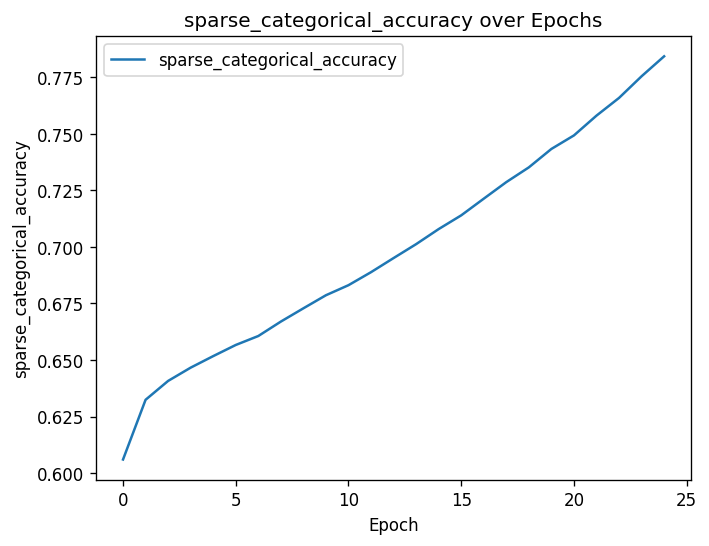

In [26]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [27]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
(CNN) -- Even though he was ill, Adam Scott could do little wrong in the early rounds at the Arnold Palmer Invitational. He led by seven shots at the halfway mark at Bay Hill in Orlando and, despite his advantage being cut entering the final round, still held a comfortable three-shot advantage as play began Sunday. Unfortunately for the Aussie, he faltered and thus missed a chance to overtake the injured Tiger Woods as the world No. 1. Matt Every of the U.S. was the unlikely winner, compiling a strong round to claim his first PGA title. Scott shot a four-over 76, hitting five bogeys, to slip to third, two shots behind Every's total of 275. It wasn't the tournament he wanted ahead of the defense of his Masters crown next month. "I didn't putt well at all today," Scott told the Golf Channel. "If nothing else it's a good reminder on how much putting practice I need to do before going to the Masters and just how important it is. "If I think back to last year, I made every putt that you expect to in that last round and ultimately that's what gave me the chance to win." Every, who trailed Scott by four shots overnight, made up ground thanks to five birdies. But two bogeys on the last three holes gave Keegan Bradley an opportunity to force a playoff. Bradley, however, missed a birdie putt at the 18th that would have forced the playoff. Every's drought was over. "It's really cool," Every, who turned pro in 2006, told reporters. "I have had a lot of looks (at wins) and I kept telling myself maybe it's going to come somewhere special. I still can't believe I won. "It's hard, it's tough man. You just never know if it's going to happen."


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Matt Every wins his first PGA title after rallying at the Arnold Palmer Invitational .
Every trailed by four shots heading into Sunday but passed Adam Scott .
Scott slipped to third at Bay Hill and finishes two shots behind the U.S.'s Every .
Scott misses a chance to overtake Tiger Woods as golf's world No. 1 .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Adam Scott had a three-shot lead entering the final round .
He missed a chance to overtake Tiger Woods at the Arnold Palmer Invitational .
Matt Every shot a four-under 68 to win his first PGA title .

In [28]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
By . Daniel Miller . PUBLISHED: . 06:17 EST, 8 October 2012 . | . UPDATED: . 09:09 EST, 8 October 2012 . A rugby league star played through the pain barrier after being kneed in the groin and suffering a ruptured testicle in a cup final match before calmly heading off to hospital to have it surgically removed. Warrington Wolves prop forward Paul Wood lost more than the match when his team went down 26-18 to Leeds in the Super League Grand Final. Mr Wood, who celebrates his 31st birthday on Wednesday, was hurt early in the second half of the match at Old Trafford, but finished the game and even appeared in a post match interview where he made no mention of his injury. Pain barrier: Rugby League star Paul Wood carried on playing and even appeared in a post match interview after suffering a ruptured testicle early in the second half of a cup final match . Joker: The dedictaed prop forward made light of the unfortunate incident on Twitter after his surgery . He is . now out of hospital after undergoing surgery overnight and even managed to joke . about the incident on Sunday morning. One of his tweets read: 'Ruptured my right testicle, got a knee 1 minute into the second half, had to have it removed.' In the afternoon he added: 'Just coming out the hospital to go home... Seriously feel like I've left something?' Referring to the team talk given by the Warrington Wolves head . coach he said: 'Tony Smith did say in his pre match team . talk last night "your balls are on the line here guys!" I didn't think . he meant literally'. Ouch: Paul Wood (left) underwent surgery on Sunday night but was back at home on Monday morning and even joked about his injury on Twitter . The father-of-two has not yet announced whether he intends to carry on playing. Other rugby players who have lost testicles have chosen to retire over fears they may lose the other. Scottish rugby Union international Anthony 'Budge' Poutney decided to throw in the towel at the age of 29 after enduring a similar injury during match in 2003. Mr Wood could have expected a little sympathy from his team mates but he was mercilessly ribbed online about the missing appendage which he suffered with unbelievable good grace. He said: 'All the jokes have come out today about my 'nuts' 'balls' 'bo***ks' Good job I can take a laugh! I could of easily got a complex haha.'


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Heroic Paul Wood, 31, played through the pain barrier for Warrington .
He was joking about the incident on Twitter just hours later .
But the father-of-two may now have to quit playing .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Paul Wood suffered a ruptured testicle in a cup final .
The Warrington prop forward carried on playing and even appeared in a post match interview .
He was later taken to hospital for surgery .

In [29]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
A film director has documented how his family went bankrupt after his father became obsessed with Beanie Babies. Chris Robinson's father started collecting the cuddly toys in the belief they would make a great investment. But the Los Angeles family realised there was a problem when, after spending $100,000 on the stuffed animals, there was still no return on the investment. Scroll down for video . Chris Robinson's father (pictured) started collecting Beanie Babies in the hope of making enough money to send his three sons to college . The family spent $100,000 on the toys, but realised there was a problem when there was no return on the investment . Mr Robinson's entire family were roped into collecting the toys. Pictured is his younger brother . Mr Robinson has now filmed his family as they talk about the years spent collecting the Beanie Babies, in a bid to make enough money to send the three sons to college. His film, Bankrupt by Beanies, shows how his father's obsession consumed the family's activities as they attempted to collect as many as they could. Surrounded by boxes of the cuddly . toys, his father opens the film by telling the camera: 'This is like . admitting to a drug addiction, you know, you want to forget it.' He . goes on to describe how at first his three sons enjoyed collecting the . toys, but one by one their interest waned to the point where he only . continued to pursue his obsession in the hope it would make a financial . return. The film-maker's mother (pictured) has said they initially thought they could make a profit on the toys - but they never sold them . The family's home has boxes piled high full of the stuffed toys . The Beanie Babies were first introduced to the public in 1993, when creators Ty Warner Inc, which later became Ty Inc, launched its original line consisting of just nine characters. Over the next few years however hundreds of different types of Beanie Baby were produced as they gained in popularity. The company made an empire worth more than $6billion from the toys, boosted by the increase in people buying them as popular collectibles in 1995. At the peak of the collecting craze, many believed the designs which had been 'retired' would rise in value. Chris Robinson was led to believe the toys were collectibles after he bought the first one, which sparked his obsession. The craze however failed to last much longer than 1999, when Ty announced it would no longer be making the toys, and even made a bear called The End. Nowadays hundreds of the cuddly toys are sold on sites such as ebay - but they are not always worth as much money as collectors would originally have hoped. Sellers this afternoon were advertising 'bulk' lots of Beanie Babies, which included up to 15 of the toys for just $29.99. There are however some which have certainly increased in price, including one 'ultra rare' Ty Princess Diana Di Beanie Baby, first edition, which was listed on the site at $6,500 this afternoon and had seven watchers. He says that is when . he started to think: 'Well what am I doing it for? Ok, I'm doing it for . a college education, which so far has never taken place because I guess . I lost a lot of money.' His wife goes on to say how the family were under the impression they could make money from the toys. She says: 'Probably from about six months from when we started buying them we were able to realise we could buy them then turn around and make a profit on them - although that was the plan, it never happened because we never sold them, we just bought them.' Mr Robinson has now told Dazeddigital.com how the entire family became wrapped up in the obsession. He said: 'It became this all-consuming family activity, filling up any free time that wasn’t already earmarked for school or our youth hockey teams.' He even says one of his friends had to go to hospital because he ate too much McDonalds in a bid to gather the Beanie Babies. He said the first Beanies were bought when his younger brother Taylor was with his parents in Boston where he saw one of the toys and wanted one. His father was then told they were collectors items, which led the family into the obsession over the next few years. But now he says he has little hope of ever seeing the money spent on the toys again. He . said: 'The plan going in was for them to pay for our college tuition, . but it became pretty clear that wasn’t going to happen for us. 'Maybe by the time our kids graduate high school they’ll have made a comeback.' Mr Robinson's father was told the toys would become valuable, but the family are still waiting for them to be in fashion again .


<font color='cyan' size='4'><strong>Summary: </strong></font>




<center><font color='Yellow' size='6'><strong>Summary as per Dataset:</strong></font></center>

Father began collecting toys hoping they could fund sons through college .
But they realised mistake after no return from spending $100,000 .
Now Chris Robinson has made a short film documenting the obsession .

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>

You are a highly advanced language model designed to summarize news articles concisely and accurately. Your task is to summarise news articles such that it captures the main points, key details, and overall context. The summary should be clear, coherent, and should highlight the most important aspects of the news article.
Carefully read the news article given in the 'News' section, and provide a summary of the news article highlighting the main points, key details, and overall context.


<font color='crimson' size='4'><strong>News: </strong></font>
A film director has documented how his family went bankrupt after his father became obsessed with Beanie Babies. Chris Robinson's father started collecting the cuddly toys in the belief they would make a great investment. But the Los Angeles family realised there was a problem when, after spending $100,000 on the stuffed animals, there was still no return on the investment. Scroll down for video . Chris Robinson's father (pictured) started collecting Beanie Babies in the hope of making enough money to send his three sons to college . The family spent $100,000 on the toys, but realised there was a problem when there was no return on the investment . Mr Robinson's entire family were roped into collecting the toys. Pictured is his younger brother . Mr Robinson has now filmed his family as they talk about the years spent collecting the Beanie Babies, in a bid to make enough money to send the three sons to college. His film, Bankrupt by Beanies, shows how his father's obsession consumed the family's activities as they attempted to collect as many as they could. Surrounded by boxes of the cuddly . toys, his father opens the film by telling the camera: 'This is like . admitting to a drug addiction, you know, you want to forget it.' He . goes on to describe how at first his three sons enjoyed collecting the . toys, but one by one their interest waned to the point where he only . continued to pursue his obsession in the hope it would make a financial . return. The film-maker's mother (pictured) has said they initially thought they could make a profit on the toys - but they never sold them . The family's home has boxes piled high full of the stuffed toys . The Beanie Babies were first introduced to the public in 1993, when creators Ty Warner Inc, which later became Ty Inc, launched its original line consisting of just nine characters. Over the next few years however hundreds of different types of Beanie Baby were produced as they gained in popularity. The company made an empire worth more than $6billion from the toys, boosted by the increase in people buying them as popular collectibles in 1995. At the peak of the collecting craze, many believed the designs which had been 'retired' would rise in value. Chris Robinson was led to believe the toys were collectibles after he bought the first one, which sparked his obsession. The craze however failed to last much longer than 1999, when Ty announced it would no longer be making the toys, and even made a bear called The End. Nowadays hundreds of the cuddly toys are sold on sites such as ebay - but they are not always worth as much money as collectors would originally have hoped. Sellers this afternoon were advertising 'bulk' lots of Beanie Babies, which included up to 15 of the toys for just $29.99. There are however some which have certainly increased in price, including one 'ultra rare' Ty Princess Diana Di Beanie Baby, first edition, which was listed on the site at $6,500 this afternoon and had seven watchers. He says that is when . he started to think: 'Well what am I doing it for? Ok, I'm doing it for . a college education, which so far has never taken place because I guess . I lost a lot of money.' His wife goes on to say how the family were under the impression they could make money from the toys. She says: 'Probably from about six months from when we started buying them we were able to realise we could buy them then turn around and make a profit on them - although that was the plan, it never happened because we never sold them, we just bought them.' Mr Robinson has now told Dazeddigital.com how the entire family became wrapped up in the obsession. He said: 'It became this all-consuming family activity, filling up any free time that wasn’t already earmarked for school or our youth hockey teams.' He even says one of his friends had to go to hospital because he ate too much McDonalds in a bid to gather the Beanie Babies. He said the first Beanies were bought when his younger brother Taylor was with his parents in Boston where he saw one of the toys and wanted one. His father was then told they were collectors items, which led the family into the obsession over the next few years. But now he says he has little hope of everSending stuffed animals to school after spending $100,000 .
Father-of-three Chris Robinson was told the toys were collectibles .
But now he says he has little hope of ever making a profit from the purchase .